In [1]:
library(ggplot2)
library(pscl)
library(boot)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


### Examples of Zero-Inflated Poisson regression

### Description of the data

In [2]:
zinb <- read.csv("./datasets/fish.csv")
zinb <- within(zinb, {
      nofish <- factor(nofish)
      livebait <- factor(livebait)
      camper <- factor(camper)})
summary(zinb)

 nofish  livebait camper     persons          child             xb           
 0:176   0: 34    0:103   Min.   :1.000   Min.   :0.000   Min.   :-3.275050  
 1: 74   1:216    1:147   1st Qu.:2.000   1st Qu.:0.000   1st Qu.: 0.008267  
                          Median :2.000   Median :0.000   Median : 0.954550  
                          Mean   :2.528   Mean   :0.684   Mean   : 0.973796  
                          3rd Qu.:4.000   3rd Qu.:1.000   3rd Qu.: 1.963855  
                          Max.   :4.000   Max.   :3.000   Max.   : 5.352674  
       zg              count        
 Min.   :-5.6259   Min.   :  0.000  
 1st Qu.:-1.2527   1st Qu.:  0.000  
 Median : 0.6051   Median :  0.000  
 Mean   : 0.2523   Mean   :  3.296  
 3rd Qu.: 1.9932   3rd Qu.:  2.000  
 Max.   : 4.2632   Max.   :149.000  

Warning message:
"Transformation introduced infinite values in continuous x-axis"`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 142 rows containing non-finite values (stat_bin)."

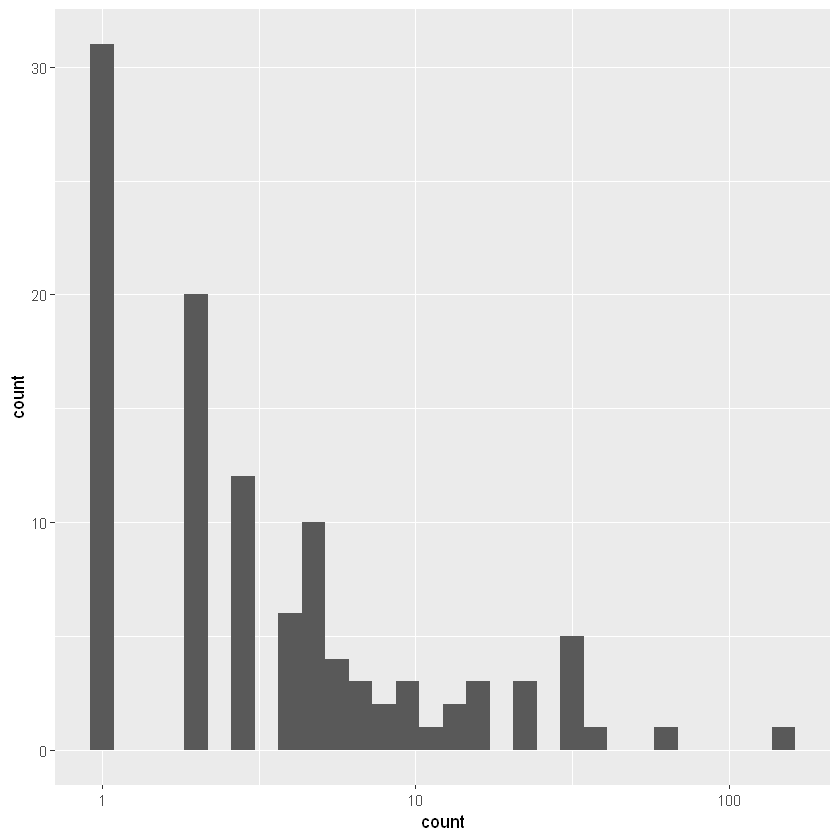

In [3]:
## histogram with x axis in log10 scale
ggplot(zinb, aes(count)) + geom_histogram() + scale_x_log10()

### Analysis methods you might consider

### Zero-inflated Poisson regression

In [4]:
summary(m1 <- zeroinfl(count ~ child + camper | persons, data = zinb))


Call:
zeroinfl(formula = count ~ child + camper | persons, data = zinb)

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-1.2369 -0.7540 -0.6080 -0.1921 24.0847 

Count model coefficients (poisson with log link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.59789    0.08554  18.680   <2e-16 ***
child       -1.04284    0.09999 -10.430   <2e-16 ***
camper1      0.83402    0.09363   8.908   <2e-16 ***

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.2974     0.3739   3.470 0.000520 ***
persons      -0.5643     0.1630  -3.463 0.000534 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Number of iterations in BFGS optimization: 12 
Log-likelihood: -1032 on 5 Df

In [5]:
mnull <- update(m1, . ~ 1)
pchisq(2 * (logLik(m1) - logLik(mnull)), df = 3, lower.tail = FALSE)

'log Lik.' 4.041242e-41 (df=5)

In [6]:
summary(p1 <- glm(count ~ child + camper, family = poisson, data = zinb))


Call:
glm(formula = count ~ child + camper, family = poisson, data = zinb)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7736  -2.2293  -1.2024  -0.3498  24.9492  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.91026    0.08119   11.21   <2e-16 ***
child       -1.23476    0.08029  -15.38   <2e-16 ***
camper1      1.05267    0.08871   11.87   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2958.4  on 249  degrees of freedom
Residual deviance: 2380.1  on 247  degrees of freedom
AIC: 2723.2

Number of Fisher Scoring iterations: 6


In [7]:
vuong(p1, m1)

Vuong Non-Nested Hypothesis Test-Statistic: 
(test-statistic is asymptotically distributed N(0,1) under the
 null that the models are indistinguishible)
-------------------------------------------------------------
              Vuong z-statistic             H_A    p-value
Raw                   -3.574254 model2 > model1 0.00017561
AIC-corrected         -3.552392 model2 > model1 0.00019087
BIC-corrected         -3.513900 model2 > model1 0.00022079


In [8]:
dput(coef(m1, "count"))

c(`(Intercept)` = 1.59788828690411, child = -1.04283909332231, 
camper1 = 0.834023618148891)


In [9]:
dput(coef(m1, "zero"))

c(`(Intercept)` = 1.29744027908309, persons = -0.564347365357873
)


In [10]:
f <- function(data, i) {
    require(pscl)
    m <- zeroinfl(count ~ child + camper | persons, data = data[i, ],
         start = list(count = c(1.598, -1.0428, 0.834), zero = c(1.297, -0.564)))
         as.vector(t(do.call(rbind, coef(summary(m)))[, 1:2]))}

set.seed(10)
res <- boot(zinb, f, R = 1200, parallel = "snow", ncpus = 4)
## print results
res


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = zinb, statistic = f, R = 1200, parallel = "snow", 
    ncpus = 4)


Bootstrap Statistics :
        original        bias    std. error
t1*   1.59788855 -0.0451465238  0.29947818
t2*   0.08553816  0.0036239301  0.01659791
t3*  -1.04283849  0.0112733739  0.41120836
t4*   0.09998829  0.0042049209  0.01580662
t5*   0.83402218  0.0003032752  0.40949791
t6*   0.09362679  0.0041210988  0.01524233
t7*   1.29743916  0.0211989510  0.47396484
t8*   0.37385225  0.0069068078  0.03657407
t9*  -0.56434716 -0.0265559366  0.26840571
t10*  0.16296381  0.0039579582  0.03019734

In [11]:
## basic parameter estimates with percentile and bias adjusted CIs
parms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
         out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "bca"))
                 with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], bcaLL = bca[4], bcaLL = bca[5])) }))

## add row names
row.names(parms) <- names(coef(m1))

## print results
parms

,Est,pLL,pUL,bcaLL,bcaLL
count_(Intercept),1.5978885,0.929548809,2.0891957,1.052591464,2.21402500
count_child,-1.0428385,-1.778733547,-0.1686651,-1.727480382,-0.09541710
count_camper1,0.8340222,0.008795793,1.5978058,0.001069699,1.58913696
zero_(Intercept),1.2974392,0.458982712,2.2596422,0.441060605,2.21684371
zero_persons,-0.5643472,-1.100952918,-0.1167136,-1.061884331,-0.03569355


In [12]:
## compare with normal based approximation
confint(m1)

,2.5 %,97.5 %
count_(Intercept),1.4302366,1.7655400
count_child,-1.2388125,-0.8468657
count_camper1,0.6505185,1.0175288
zero_(Intercept),0.5647033,2.0301772
zero_persons,-0.8837505,-0.2449442


In [13]:
## exponentiated parameter estimates with percentile and bias adjusted CIs
expparms <- t(sapply(c(1, 3, 5, 7, 9), function(i) {
            out <- boot.ci(res, index = c(i, i + 1), type = c("perc", "bca"), h = exp)
                   with(out, c(Est = t0, pLL = percent[4], pUL = percent[5], bcaLL = bca[4], bcaLL = bca[5])) }))

## add row names
row.names(expparms) <- names(coef(m1))

## print results
expparms

,Est,pLL,pUL,bcaLL,bcaLL
count_(Intercept),4.9425854,2.5333659,8.0784160,2.8650662,9.1524811
count_child,0.3524528,0.1688519,0.8447918,0.1777317,0.9089937
count_camper1,2.3025614,1.0088346,4.9421772,1.0010703,4.8995186
zero_(Intercept),3.6599122,1.5824634,9.5796696,1.5543549,9.1783157
zero_persons,0.5687313,0.3325540,0.8898401,0.3458036,0.9649360


In [14]:
newdata1 <- expand.grid(0:3, factor(0:1), 1:4)
colnames(newdata1) <- c("child", "camper", "persons")
newdata1 <- subset(newdata1, subset=(child<=persons))
newdata1$phat <- predict(m1, newdata1)

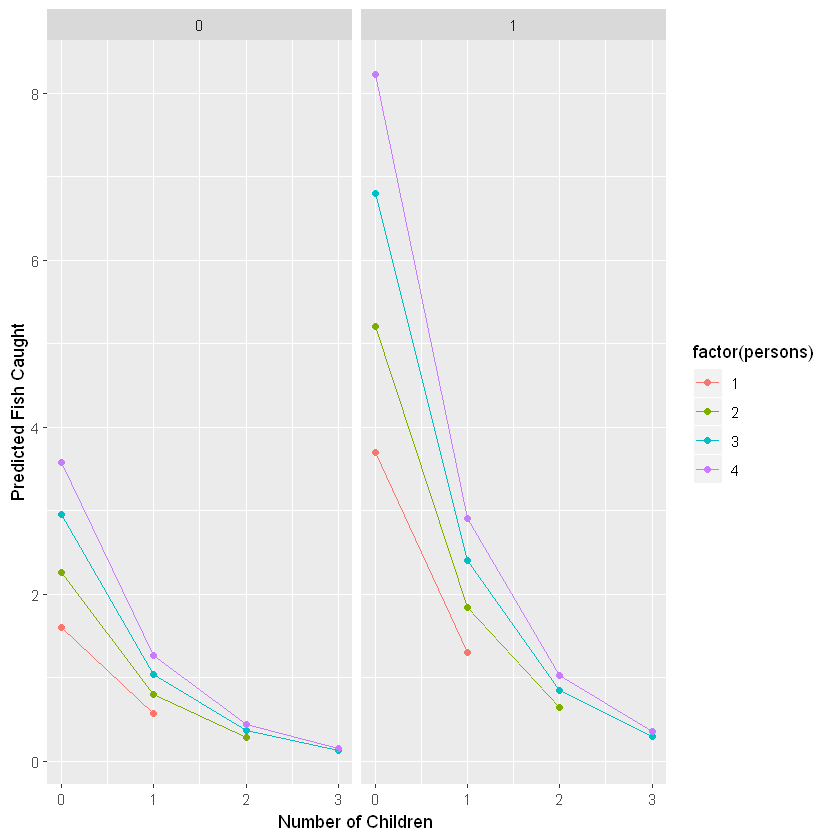

In [15]:
ggplot(newdata1, aes(x = child, y = phat, colour = factor(persons))) +
    geom_point() + geom_line() + facet_wrap(~camper) + labs(x = "Number of Children", y = "Predicted Fish Caught")

### Things to consider